In [1]:
import os
import os.path
import itertools
import pandas as pd

def get_patient_id(dirpath):
    dircomp = dirpath.split('_')
    return dircomp[-1].split('\\')[0]

def get_region(filename):
    if 'difference' in filename:
        return 'M-H Difference'
    elif 'choriod' in filename:
        return 'Choriod'
    elif 'retina' in filename:
        return 'Retina'
    elif 'homogenous' in filename:
        return 'Homogenous'
    elif 'match' in filename:
        return 'Match points'

def pid_feature_ranking(filepath):
    '''
        Input: filepath - path to mutual*2eyes.txt
        Output: dictionary of multi-index dataframe where the key are pid
                multi-index is [region], and [denoise, feature, MD] as first and second levels, respectively
    '''
    patient_folders = []
    feature_ranks = dict()
    for (dirpath, dirnames, filenames) in os.walk(filepath):
        #print('{}\n\t{}\n\t{}\n\n'.format(dirpath, dirnames, filenames))
        
        fileexist = False
        for f in filenames: 
            if 'mutual' and '2eyes' in f: 
                fileexist = True
                break
                    
        if dirnames and '2017' in dirnames[0]:
            patient_folders = dirnames
            #print(dirnames)
        elif fileexist: 
            pid = get_patient_id(dirpath)
            #print(pid)
            multiple_dataframes = []
            for fidx in range(0,len(filenames)):
                fname, file_extension = os.path.splitext(filenames[fidx])
                if (file_extension != '.txt') or ('mutual' and '2eyes' not in fname): continue
                #print('\t{} {}'.format(file_extension, filenames[fidx]))
                file = os.path.join(dirpath, filenames[fidx])
                region = get_region(file)
                data = pd.read_csv(file)
                data.columns = pd.MultiIndex.from_product([[region], data.columns])
                multiple_dataframes.append(data)
            if fidx == len(filenames)-1:
                if pid not in feature_ranks: 
                    feature_ranks[pid] = pd.concat(multiple_dataframes, axis = 1)
                    #print(pid)
    return feature_ranks, patient_folders

def feature_name_parts(featurename):
    cpos = [pos for pos in range(0, len(featurename)) if featurename[pos].isdigit()]
    element = int(''.join(featurename[cpos[0]:]))
    name = featurename[:cpos[0]]
    if name == 'MIND': name = 'D-MIND'
    #print('F:{}, E:{}, N:{}, P:{}'.format(featurename, element,name,cpos))
    return name, element

def unpack_featurename(dataframe, reserved_column = ['MD']):
    '''
        dataframe: after selecting pid, type of md or region, grouped by and get group denoise method
        feature_ranks['cc0008']['M-H Difference'].groupby('Denoise').get_group('BM3D')
        reserved_column: list of columns e.g., ['MD']
    '''
    unpacked_dataframe = pd.DataFrame(dataframe, index = dataframe.index, columns=reserved_column)
    unpacked_dataframe['Feature'], unpacked_dataframe['Element'] = \
                 zip(*dataframe['Feature'].apply(lambda x: feature_name_parts(x)) )
    return unpacked_dataframe

def get_patient_folder(pid, patient_folders, filepath):
    for folder in patient_folders: 
        if pid in folder: 
            patient_folder = os.path.join(filepath, folder)
    return patient_folder  

In [2]:
# plot M-H difference
filepath = 'C:/Users/Ja/Dropbox/data'

pid = 'cc0008'
region = 'M-H Difference'

feature_ranks,patient_folders = pid_feature_ranking(filepath)
feature_ranks[pid].head(3)

Choriod                   Homogenous                   M-H Difference  \
  Denoise Feature        MD    Denoise Feature        MD        Denoise   
0    None    AG11  0.494988       None     AG2  0.528982           BM3D   
1    None     AG8  0.494971       None     AG5  0.528941           FNLM   
2    None    AG17  0.494964       None     AG8  0.528666           None   

                    Match points                    Retina                    
  Feature        MD      Denoise Feature        MD Denoise Feature        MD  
0   MIND9  0.438514         FNLM     RL9  0.622080    None     AG5  0.536711  
1   MIND9  0.429270         BM3D     RL9  0.615190    None    AG11  0.536621  
2   MIND9  0.355096         FNLM     RL5  0.612285    None     AG2  0.536328

In [3]:
feature_ranks[pid][region].head(3)



,Denoise,Feature,MD
0,BM3D,MIND9,0.438514
1,FNLM,MIND9,0.429270
2,None,MIND9,0.355096


In [4]:
def compute_start_end_indices(feature_types = ['MIND', 'AG', 'CHO', 'COC', 'RL'], \
                              numel = [14, 18, 6, 8, 10]):
    
    hue = {'red':0, 'yellow':60, 'green':120, 'blue':240, 'magenta':300, 'cyan':180}
    starts = []
    ends = []
    for n in range(0,len(numel)):
        if n == 0: starts.append(0)
        else: starts.append(ends[n-1]+1)
        ends.append(starts[n]+numel[n]-1)

    #print('S {}, E {}'.format(starts, ends))

    d = {'Start' : pd.Series(starts,index=feature_types),
         'End' : pd.Series(ends,index=feature_types)}
    df = pd.DataFrame(d)
    
    colors = list(hue.values())
    df.loc[:,'Color'] = pd.Series(colors[:len(feature_types)], index=df.index)
    
    return df

se_info = compute_start_end_indices()
#se_info.loc['MIND']
se_info

,End,Start,Color
MIND,13,0,120
AG,31,14,0
CHO,37,32,240
COC,45,38,60
RL,55,46,300


In [5]:
import colorsys
import re

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb #   '#%02x%02x%02x'

def hsv_to_hex(hue, sat = 100, light=100):
    rgb = colorsys.hsv_to_rgb(hue/360, sat/100,light/100)
    rgb_ = (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255) )
    hex_color = rgb_to_hex(rgb_)
    #print('\tHSV {} RGB {} Hex {}'.format((hue,sat,light), rgb_, hex_color))
    return hex_color


rgb = (53, 112, 119)
rgb_to_hex(rgb)
hsv_to_hex(187, 47, 55)

'#4a848c'

In [6]:
# map value
denoise_method_name = 'BM3D'
dataframe = feature_ranks[pid][region]

## func
denoised_df = dataframe.groupby('Denoise').get_group(denoise_method_name)
denoised_df = unpack_featurename(denoised_df)
denoised_df.head(5)

,MD,Feature,Element
0,0.438514,D-MIND,9
3,0.333847,D-MIND,5
4,0.312974,D-MIND,3
8,0.273874,D-MIND,10
11,0.260802,D-MIND,11


In [7]:
import numpy as np

def feature_rank_map(dataframe, denoise_method_name, brightness=100, width = 8, height=7):
    
    def oneD_twoD(array, width, height):
        return np.reshape(array, (height, width))
    
    def linear_scale(i, input_min, input_max, output_min=50, output_max=100):
        return (i-input_min)*(output_max-output_min)/(input_max-input_min) + output_min
    
    def compute_color_pallete(se_table, feature_nelements, brightness= 100, min_saturation = 20, \
                              max_saturation = 100):
        color_pallete = dict()
        for ftype, numel in feature_nelements.items():
            hue = se_table.loc[ftype]['Color']
            #print('Feature:{}, Hue:{}'.format(ftype, hue))
            for element in range(1, numel+1):
                saturation = int(linear_scale(element, 1, numel, min_saturation, max_saturation))
                hex_color = hsv_to_hex(hue, saturation, brightness)
                color_pallete[(hue, saturation, brightness)] = hex_color
        return color_pallete
                
                
    denoised_df = dataframe.groupby('Denoise').get_group(denoise_method_name)
    denoised_df = unpack_featurename(denoised_df)
    se_table = compute_start_end_indices()

    feature_nelements = {'MIND':14, 'AG':18, 'CHO':6, 'COC':8, 'RL':10}
    rank_list = []
    anno = []
    #colors = []

    for index, row in denoised_df.iterrows():
        
        ftype = row['Feature']
        element = row['Element']
        se_info = se_table.loc[ftype]
       # print(se_info)
        rank_list.append(se_info['Start']+element-1)
        anno.append(' '.join([ftype, str(element)]))
        
    rank_map = oneD_twoD(rank_list, width, height)
    anno_map = oneD_twoD(anno, width, height)
    
    color_pallete = compute_color_pallete(se_table, feature_nelements, brightness)
    
    return rank_map, anno_map, color_pallete

In [8]:
def feature_md_rank_map(dataframe, denoise_method_name, width = 8, height=7):

    def oneD_twoD(array, width, height):
        return np.reshape(array, (height, width))

    denoised_df = dataframe.groupby('Denoise').get_group(denoise_method_name)
    denoised_df = unpack_featurename(denoised_df)
    md_list = (denoised_df['MD']).tolist()
    
    anno = [' '.join([row['Feature'], str(row['Element'])]) for index, row in denoised_df.iterrows()]

    #print('length:{} {}'.format(len(md_list), md_list))
    #print('length:{} {}'.format(len(anno), anno))
    md_map = oneD_twoD(md_list, width, height)
    anno_map = oneD_twoD(anno, width, height)

    return md_map, anno_map

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_map(value_map, anno_map, colormap, cmin, cmax, cbar_title = '', line_color = (0,0,0),\
             patient_folder=None, region = None, denoise = None, fontsize = 10.2,  \
             format_anno = 's', fig_width = 8, fig_height =7):

    f, ax = plt.subplots(figsize=(8,7))
    sns.set('paper', style="white", color_codes=True, font='Arial', font_scale = fontsize/7)
    #cmap = ListedColormap(sns.color_palette(list(colors.values())).as_hex())
    sns.heatmap(value_map, annot = anno_map, fmt=format_anno, cmap=colormap, linecolor =line_color, \
        center= (cmin+cmax)/2, cbar=True,vmin= cmin, vmax = cmax, linewidths=.5, ax=ax, \
        alpha=0.9, annot_kws={'fontname':'Arial', 'size':fontsize},
        cbar_kws={ 'label': cbar_title,'format': '%.1f', 'ticks': [cmin, (cmin+cmax)/2, cmax]})
    
    #ax.set_xlabel(ftype, size = font_size,alpha=1.0)
    #ax.set_ylabel("Mutual Descriptiveness",size = font_size,alpha=1.0)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_xticklabels(), visible=False)
    
    if patient_folder and region and denoise:
        image_file = patient_folder+'//feature_ranking_'+region+'_'+denoise+'.png';
        fig.savefig(image_file, dpi=300)
        
def subplot_Nmap(value_maps, anno_maps, colormap, cmin, cmax, cbar_title = '', line_color = (0,0,0),\
             patient_folder=None, region = None, fontsize = 10.2,  format_anno = 's', \
             fig_width = 8, fig_height =7, hspace = 6, invisible_cbar=True):
    
    # value_maps is a list of list [value_map1, value_map2]
    # anno_maps is a list of list [anno_map1, anno_map2]
    
    def each_plot(value_map, anno_map, cmin, cmax, line_color, fontsize,  format_anno, axis, cbar_visibility):
        
        sns.heatmap(value_map, annot = anno_map, fmt=format_anno, cmap=colormap, \
                    linecolor =line_color, center= (cmin+cmax)/2, cbar=cbar_visibility, \
                    vmin= cmin, vmax = cmax, linewidths=.5, ax=axis, alpha=0.9, \
                    annot_kws={'fontname':'Arial', 'size':fontsize},\
                    cbar_kws={ 'label': cbar_title,'format': '%.1f', 'ticks': [cmin, (cmin+cmax)/2, cmax]})
        plt.setp(axis.get_yticklabels(), visible=False)
        plt.setp(axis.get_xticklabels(), visible=False)
        
        #for text in ax.texts:
        #text.set_size(14)
        #    if text.get_text() == '118':
        #    text.set_size(18)
        #    text.set_weight('bold')
        #    text.set_style('italic')
        for text in axis.texts:
            text.set_weight('bold')
    
    figw, figh = fig_width, fig_height
    fig, axes= plt.subplots(nrows = 1, ncols = len(value_maps), sharey=True, figsize=(figw, figh))
    plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh)
    
    sns.set('paper', style="white", color_codes=True, font='Arial', font_scale = fontsize/7)
    
    cbar_visibility = False
    for i in range(0, len(value_maps)):
        if not invisible_cbar and i == len(value_maps)-1: cbar_visibility = True
        each_plot(value_maps[i], anno_maps[i], cmin, cmax, line_color, \
                  fontsize,  format_anno, axes[i], cbar_visibility)
    
    fig.subplots_adjust(hspace=hspace)
    plt.tight_layout()
    
    if patient_folder and region:
        image_file = patient_folder+'//feature_ranking_'+region+'.png';
        fig.savefig(image_file, dpi=300)

In [15]:
def subplot_Nmap_black_background(value_maps, anno_maps, colormap, cmin, cmax, cbar_title = '', line_color = (0,0,0),\
             patient_folder=None, region = None, fontsize = 10.2,  format_anno = 's', \
             fig_width = 7, fig_height =8, hspace = 6, width_space = 0.05, invisible_cbar=True):
    
    # value_maps is a list of list [value_map1, value_map2]
    # anno_maps is a list of list [anno_map1, anno_map2]
    
    def each_plot(value_map, anno_map, cmin, cmax, line_color, fontsize,  format_anno, axis, cbar_visibility):
        
        sns.heatmap(value_map, annot = anno_map, fmt=format_anno, cmap=colormap, \
                    linecolor =line_color, center= (cmin+cmax)/2, cbar=cbar_visibility, \
                    vmin= cmin, vmax = cmax, linewidths=.5, ax=axis, alpha=0.9, \
                    annot_kws={'fontname':'Arial', 'size':fontsize},\
                    cbar_kws={ 'label': cbar_title,'format': '%.1f', 'ticks': [cmin, (cmin+cmax)/2, cmax]})
        #axis.set_xlim([0, 7])
        #axis.set_ylim([0, 8])
        plt.setp(axis.get_yticklabels(), visible=False)
        plt.setp(axis.get_xticklabels(), visible=False)
        
        #for text in ax.texts:
        #text.set_size(14)
        #    if text.get_text() == '118':
        #    text.set_size(18)
        #    text.set_weight('bold')
        #    text.set_style('italic')
        for text in axis.texts:
            text.set_weight('bold')
    
    figw, figh = fig_width, fig_height
    fig, axes= plt.subplots(nrows = 1, ncols = len(value_maps), sharey=True, figsize=(figw, figh))
    #plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh)
    
    #sns.set('paper', style="white", color_codes=True, font='Arial', font_scale = fontsize/7)
    sns.set(style="dark", context="talk",color_codes=True, font='Arial', font_scale = fontsize/7)
    #sns.set(style="ticks", context="talk",color_codes=True, font='Arial', font_scale = fontsize/7)
    plt.style.use("dark_background")     
    sns.despine(top=True, right=True, left=True, bottom=True)
    
    cbar_visibility = False
    for i in range(0, len(value_maps)):
        if not invisible_cbar and i == len(value_maps)-1: cbar_visibility = True
        each_plot(value_maps[i], anno_maps[i], cmin, cmax, line_color, \
                  fontsize,  format_anno, axes[i], cbar_visibility)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        
    
    fig.subplots_adjust(hspace=hspace, wspace = width_space)
    #plt.tight_layout()
    
    if patient_folder and region:
        image_file = patient_folder+'//feature_ranking_'+region+'.png';
        fig.savefig(image_file, dpi=300, transparent=True)

In [ ]:
list(range(0,3))

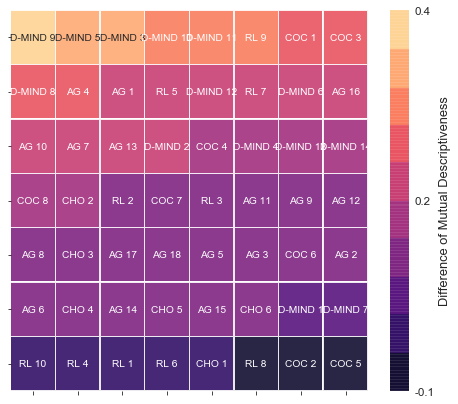

In [12]:
# plot M-H difference
filepath = 'C:/Users/Ja/Dropbox/data'

pid = 'cc0008'
region = 'M-H Difference'
denoise_method_name = 'BM3D'

feature_ranks,patient_folders = pid_feature_ranking(filepath)
dataframe = feature_ranks[pid][region]

#Color Map Web: https://matplotlib.org/users/colormaps.html
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
#colormap = ListedColormap(sns.color_palette("YlGnBu_r", 10).as_hex())
#colormap = ListedColormap(sns.color_palette("PuBu_r", 10).as_hex())
colormap = ListedColormap(sns.color_palette('magma', 10).as_hex())
cmin, cmax =-0.1,0.4
cbar_title = 'Difference of Mutual Descriptiveness'
#colormap = sns.cubehelix_palette(8, start=.5, rot=-0.75,reverse=True, as_cmap=True)
#colormap = sns.cubehelix_palette(light=1, reverse=True, as_cmap=True)
plot_map(md_map, anno_map, colormap, cmin, cmax, cbar_title, (1,1,1))

In [ ]:
# plot M-H difference
pid = 'cc0001'
region = 'M-H Difference'

feature_ranks,patient_folders = pid_feature_ranking(filepath)
dataframe = feature_ranks[pid][region]

md_maps, anno_maps = [], []
denoise_method_name = 'BM3D'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)
denoise_method_name = 'FNLM'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)

colormap = ListedColormap(sns.color_palette('magma', 10).as_hex())
cmin, cmax =-0.1,0.4
cbar_title = 'Difference of Mutual Descriptiveness'
line_color = (1,1,1)
patient_folder = get_patient_folder(pid, patient_folders, filepath)
fontsize, format_anno = 12,  's'
fig_width,fig_height = 8*2, 4*2
hspace = 4
subplot_Nmap(md_maps, anno_maps, colormap, cmin, cmax, cbar_title, line_color,\
             patient_folder, region, fontsize,  format_anno, fig_width, fig_height, hspace)

In [ ]:
# plot M-H difference
pid = 'cc0008'
region = 'M-H Difference'

feature_ranks,patient_folders = pid_feature_ranking(filepath)
dataframe = feature_ranks[pid][region]

md_maps, anno_maps = [], []
denoise_method_name = 'BM3D'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)
denoise_method_name = 'FNLM'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)

colormap = ListedColormap(sns.color_palette('magma', 10).as_hex())
cmin, cmax =-0.1,0.4
cbar_title = 'Difference of Mutual Descriptiveness'
line_color = (1,1,1)
patient_folder = get_patient_folder(pid, patient_folders, filepath)
fontsize, format_anno = 12,  's'
fig_width,fig_height = 8*2, 4*2
hspace = 4
subplot_Nmap(md_maps, anno_maps, colormap, cmin, cmax, cbar_title, line_color,\
             patient_folder, region, fontsize,  format_anno, fig_width, fig_height, hspace)

In [ ]:
# plot M-H difference
pid = 'cc0015'
region = 'M-H Difference'

feature_ranks,patient_folders = pid_feature_ranking(filepath)
dataframe = feature_ranks[pid][region]

md_maps, anno_maps = [], []
denoise_method_name = 'BM3D'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)
denoise_method_name = 'FNLM'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)

colormap = ListedColormap(sns.color_palette('magma', 10).as_hex())
cmin, cmax =-0.1,0.4
cbar_title = 'Difference of Mutual Descriptiveness'
line_color = (1,1,1)
patient_folder = get_patient_folder(pid, patient_folders, filepath)
fontsize, format_anno = 12,  's'
fig_width,fig_height = 8*2, 4*2
hspace = 4
subplot_Nmap(md_maps, anno_maps, colormap, cmin, cmax, cbar_title, line_color,\
             patient_folder, region, fontsize,  format_anno, fig_width, fig_height, hspace)

C:/Users/Ja/Dropbox/data\20170721_cc0015


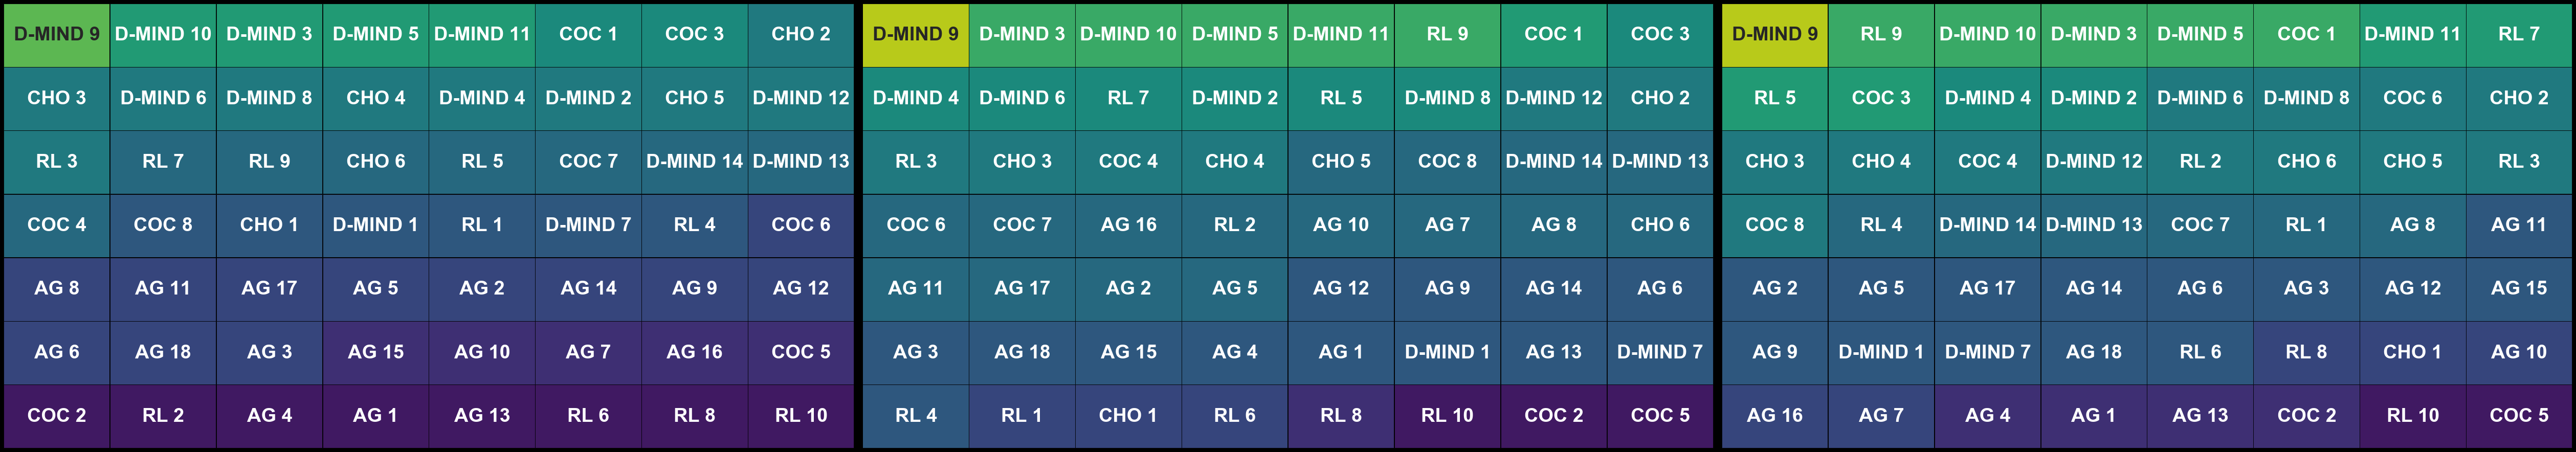

In [19]:
# plot M-H difference
pid = 'cc0015'
region = 'M-H Difference'

feature_ranks,patient_folders = pid_feature_ranking(filepath)
dataframe = feature_ranks[pid][region]

md_maps, anno_maps = [], []
denoise_method_name = 'None'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)
denoise_method_name = 'BM3D'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)
denoise_method_name = 'FNLM'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)

colormap = ListedColormap(sns.color_palette('viridis', 12).as_hex())
cmin, cmax =-.1,.4
cbar_title = 'Difference of the median of mutual descriptiveness'
line_color = (0,0,0)
patient_folder = get_patient_folder(pid, patient_folders, filepath)
fontsize, format_anno = 38,  's'
fig_width,fig_height = 45*2, 8*2
hspace = 0.01
width_space = 0.01
invisible_cbar = True
image_folder = 'C:\\Users\\Ja\\Google Drive\\mypaper\\2018_SPIE\\presentation\\figure'
subplot_Nmap_black_background(md_maps, anno_maps, colormap, cmin, cmax, cbar_title, line_color,\
             image_folder, region, fontsize,  format_anno, fig_width, fig_height, hspace, width_space,
             invisible_cbar)

#subplot_Nmap(md_maps, anno_maps, colormap, cmin, cmax, cbar_title, line_color,\
#             image_folder, region, fontsize,  format_anno, fig_width, fig_height,\
#             hspace, invisible_cbar)
print(patient_folder)

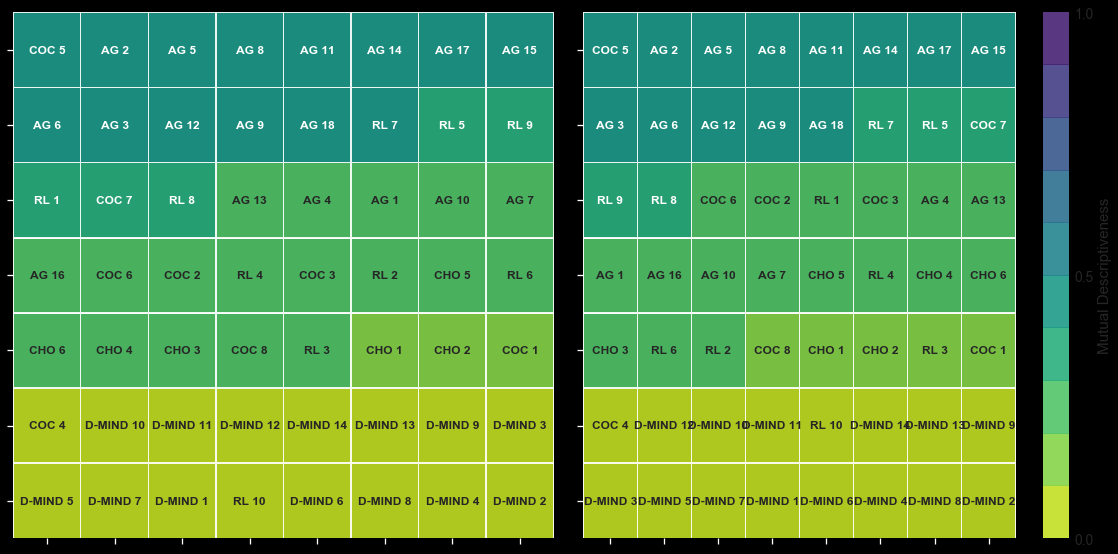

In [37]:
# plot M-H difference
pid = 'cc0008'
region = 'Homogenous'

feature_ranks,patient_folders = pid_feature_ranking(filepath)
dataframe = feature_ranks[pid][region]

md_maps, anno_maps = [], []
denoise_method_name = 'BM3D'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)
denoise_method_name = 'FNLM'
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
md_maps.append(md_map)
anno_maps.append(anno_map)

colormap = ListedColormap(sns.color_palette('viridis_r', 10).as_hex())
cmin, cmax =0.,1.
cbar_title = 'Mutual Descriptiveness'
line_color = (1,1,1)
patient_folder = get_patient_folder(pid, patient_folders, filepath)
fontsize, format_anno = 12,  's'
fig_width,fig_height = 8*2, 4*2
hspace = 4
subplot_Nmap(md_maps, anno_maps, colormap, cmin, cmax, cbar_title, line_color,\
             patient_folder, region, fontsize,  format_anno, fig_width, fig_height, hspace)

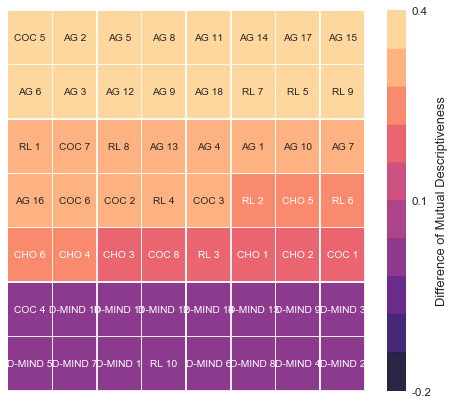

In [38]:
####################################

denoise_method_name = 'BM3D'
dataframe = feature_ranks[pid][region]
#brightness = 75
#rank_map, anno_map, colors = feature_rank_map(dataframe, denoise_method_name,brightness)

# plot using feature-based color map
#sns.palplot(sns.color_palette(list(colors.values())))    
#colormap = ListedColormap(sns.color_palette(list(colors.values())).as_hex())
#cmin, cmax =1, 56
#plot_map(rank_map, anno_map, colormap, cmin, cmax)

# plot using md color map
md_map, anno_map = feature_md_rank_map(dataframe, denoise_method_name)
colormap = ListedColormap(sns.color_palette('magma', 10).as_hex())
cmin, cmax =-0.2,0.4
cbar_title = 'Difference of Mutual Descriptiveness'
#colormap = sns.cubehelix_palette(8, start=.5, rot=-0.75,as_cmap=True)#sns.cubehelix_palette(light=1, as_cmap=True)
plot_map(md_map, anno_map, colormap, cmin, cmax, cbar_title, (1,1,1))
#print(md_map)